<a href="https://colab.research.google.com/github/cruzjulio10/AST/blob/master/UDLA_Modelos_Lead_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Lead Score

## Carga de librerías

In [ ]:
import pandas as pd
import numpy as np
import os

# Bibliotecas de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Herramientas de preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Carga de datos de Kaggle

In [ ]:
# Descargar la última versión del dataset desde Kaggle
import kagglehub
path = kagglehub.dataset_download("amritachatterjee09/lead-scoring-dataset")

# Encontrar el archivo CSV dentro de la carpeta descargada
dataset_folder = path  # Directorio donde se descargó el dataset
csv_files = [f for f in os.listdir(dataset_folder) if f.endswith(".csv")]

if csv_files:
    dataset_path = os.path.join(dataset_folder, csv_files[0])  # Tomar el primer archivo CSV encontrado
    # Cargar el dataset en un DataFrame de pandas
    data = pd.read_csv(dataset_path)

    # Exploración inicial de los datos
    print("Primeras filas del conjunto de datos:")
    print(data.head(), "\n")

    print("Información general del conjunto de datos:")
    print(data.info(), "\n")

    print("Descripción estadística de las variables numéricas:")
    print(data.describe())


100%|██████████| 411k/411k [00:00<00:00, 790kB/s]

Extracting files...


Primeras filas del conjunto de datos:
                            Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit  

## Visualización de valores faltantes

Antes de manipular los datos, visualizamos los valores nulos (faltantes) para entender la magnitud de los datos perdidos en cada columna. Esto nos ayudará a decidir cómo tratarlos

Valores nulos por columna:
Lead Quality                                     4767
Asymmetrique Profile Score                       4218
Asymmetrique Activity Score                      4218
Asymmetrique Profile Index                       4218
Asymmetrique Activity Index                      4218
Tags                                             3353
Lead Profile                                     2709
What matters most to you in choosing a course    2709
What is your current occupation                  2690
Country                                          2461
How did you hear about X Education               2207
Specialization                                   1438
City                                             1420
TotalVisits                                       137
Page Views Per Visit                              137
Last Activity                                     103
Lead Source                                        36
dtype: int64


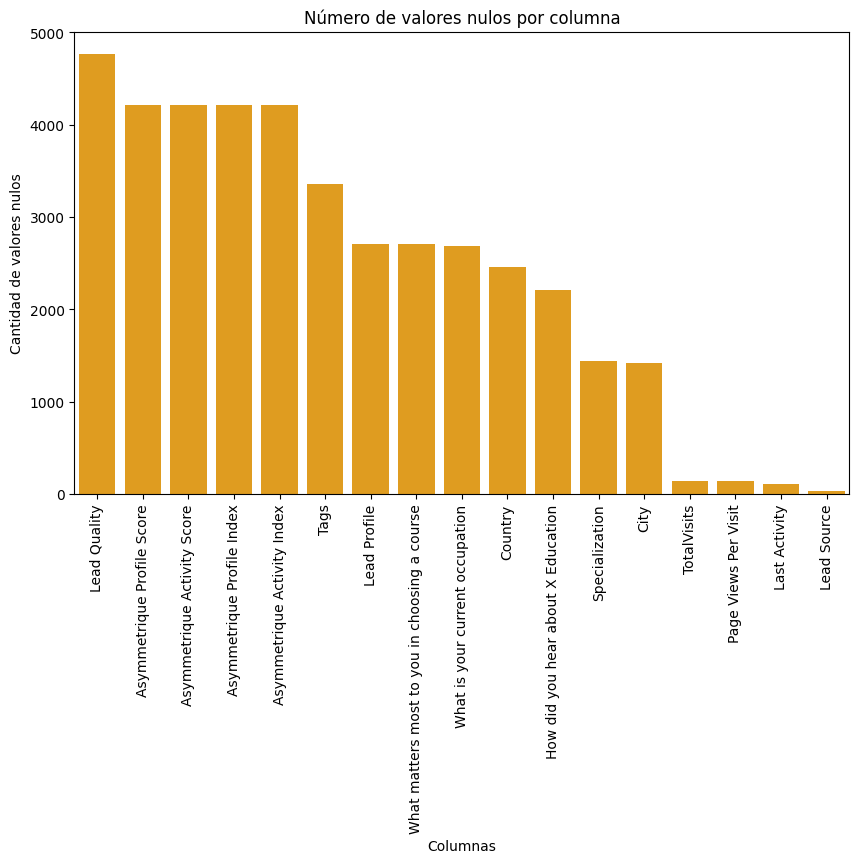

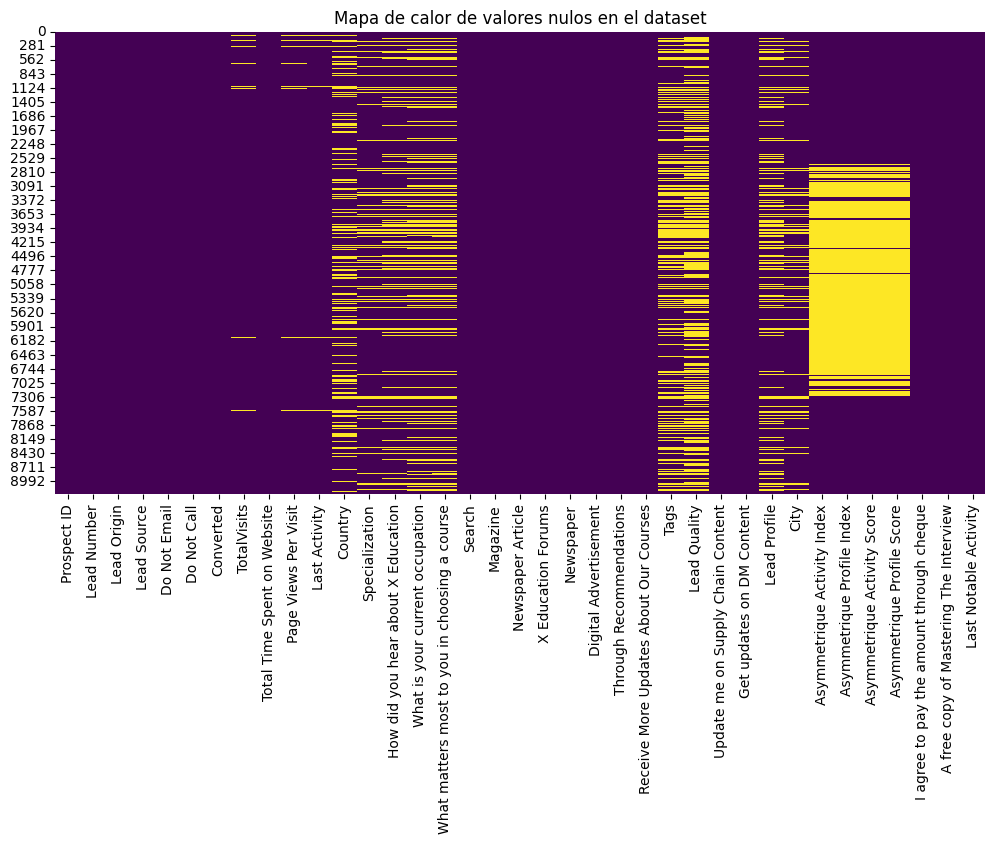

In [ ]:
# Calcular el número de valores nulos por columna
missing_counts = data.isnull().sum()

# Filtrar solo columnas con al menos 1 valor nulo
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print("Valores nulos por columna:")
print(missing_counts)

# Visualizar gráficamente los valores nulos por columna
plt.figure(figsize=(10,6))
sns.barplot(x=missing_counts.index, y=missing_counts.values, color='orange')
plt.xticks(rotation=90)
plt.title("Número de valores nulos por columna")
plt.ylabel("Cantidad de valores nulos")
plt.xlabel("Columnas")
plt.show()

# Visualizar matriz de valores nulos (True = valor nulo, False = no nulo)
plt.figure(figsize=(12,6))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title("Mapa de calor de valores nulos en el dataset")
plt.show()


In [ ]:
# Calcular el número de valores nulos por columna
missing_counts = data.isnull().sum()

# Filtrar solo columnas con al menos 1 valor nulo
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print("Valores nulos por columna:")
print(missing_counts)

Valores nulos por columna:
Lead Quality                                     4767
Asymmetrique Profile Score                       4218
Asymmetrique Activity Score                      4218
Asymmetrique Profile Index                       4218
Asymmetrique Activity Index                      4218
Tags                                             3353
Lead Profile                                     2709
What matters most to you in choosing a course    2709
What is your current occupation                  2690
Country                                          2461
How did you hear about X Education               2207
Specialization                                   1438
City                                             1420
TotalVisits                                       137
Page Views Per Visit                              137
Last Activity                                     103
Lead Source                                        36
dtype: int64


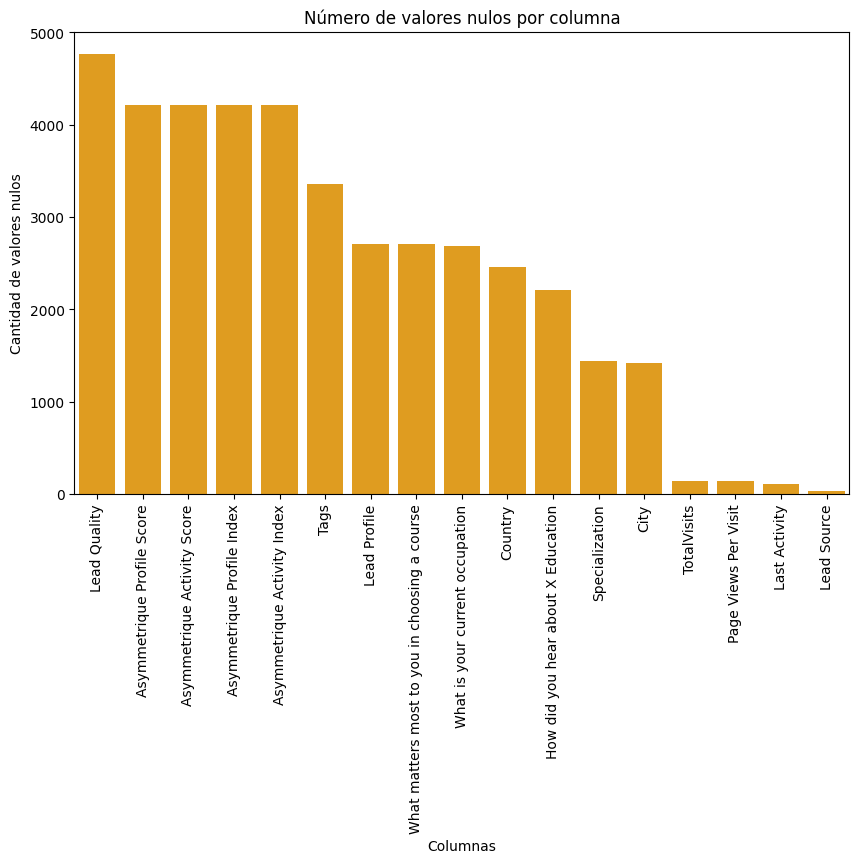

In [ ]:
# Visualizar gráficamente los valores nulos por columna
plt.figure(figsize=(10,6))
sns.barplot(x=missing_counts.index, y=missing_counts.values, color='orange')
plt.xticks(rotation=90)
plt.title("Número de valores nulos por columna")
plt.ylabel("Cantidad de valores nulos")
plt.xlabel("Columnas")
plt.show()

En el gráfico de barras anterior, podemos observar cuántos datos faltan en cada columna. Vemos, por ejemplo, que columnas como Lead Quality o las relacionadas con Asymmetrique tienen una gran cantidad de valores faltantes, mientras que otras como Lead Source o TotalVisits tienen relativamente pocos valores nulos

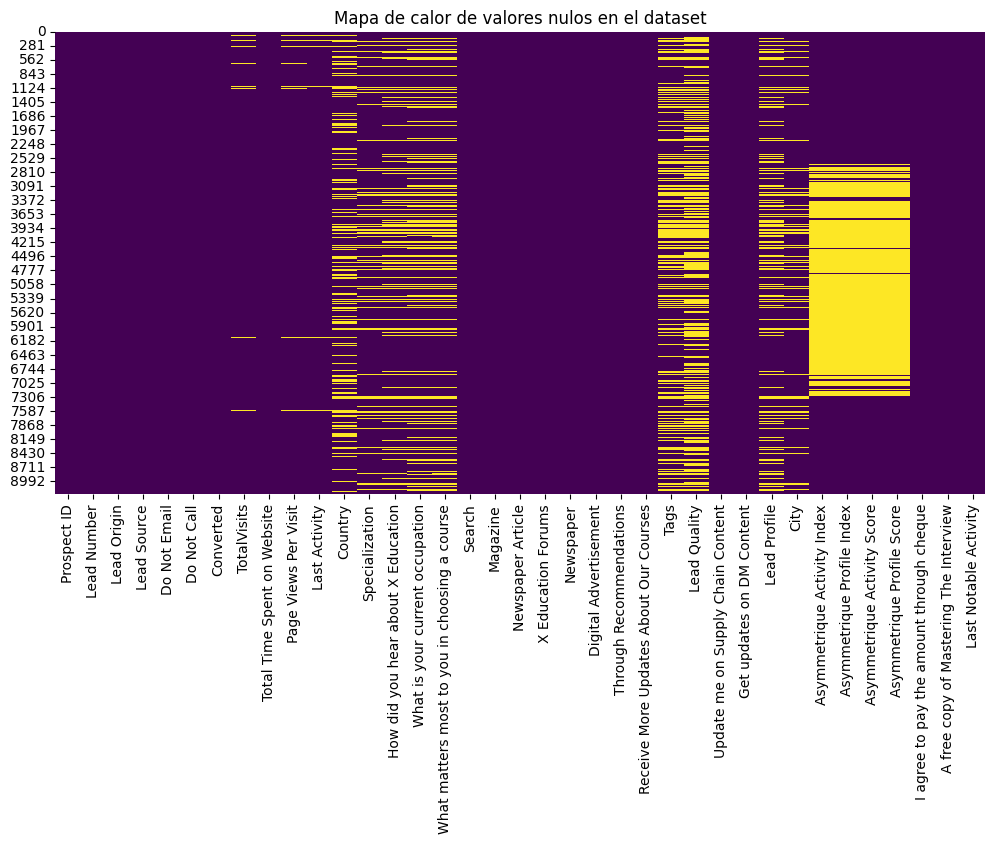

In [ ]:
# Visualizar matriz de valores nulos (True = valor nulo, False = no nulo)
plt.figure(figsize=(12,6))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title("Mapa de calor de valores nulos en el dataset")
plt.show()


El mapa de calor nos muestra la distribución de los valores faltantes a lo largo de todo el dataset, donde las franjas claras indican datos faltantes. Estos análisis visuales nos sugieren qué columnas pueden requerir eliminaciones o imputaciones para manejar los valores faltantes.

## Tratamiento de valores faltantes

A continuación, realizaremos la limpieza de los datos faltantes. Dependiendo del caso, algunas columnas o filas con muchos valores nulos se eliminarán y otras serán imputadas (rellenadas) con valores adecuados. Explicamos nuestras decisiones:

Columnas poco informativas o con muchos nulos: Eliminaremos columnas que no aportan valor al modelo o tienen un porcentaje muy alto de valores faltantes. Por ejemplo:

1.   Prospect ID y Lead Number son identificadores únicos para cada registro, por lo que no son útiles para predicción. Se eliminarán.
2. Lead Quality tiene más del 50% de datos faltantes. Dado que tantos valores
están ausentes, no es confiable; eliminaremos esta columna.
3. Columnas relacionadas con Asymmetrique (Asymmetrique Activity Index, Asymmetrique Profile Index, Asymmetrique Activity Score, Asymmetrique Profile Score) también tienen casi la mitad de sus datos faltantes. Además, representan puntuaciones cuyo significado puede no ser crítico para nuestro modelo. Para simplificar, eliminaremos estas columnas.

Valores 'Select': En varias columnas categóricas (por ejemplo, Lead Profile, City, Specialization, etc.), el valor "Select" indica que el cliente no eligió ninguna opción, por lo que en la práctica representa un valor faltante. Reemplazaremos todas las apariciones de "Select" con NaN para tratarlos explícitamente como datos faltantes.


Filas con pocos valores nulos: Si solo unos pocos registros presentan valores nulos en ciertas columnas, podemos eliminarlos. Por ejemplo, TotalVisits y Page Views Per Visit tienen relativamente pocos valores nulos; es razonable eliminar esas filas completas ya que son una fracción pequeña del total.

Imputación de valores faltantes: Para otras columnas categóricas importantes con valores faltantes, rellenaremos con una categoría especial o con el valor más frecuente:


1. En categorías como Country, Specialization, How did you hear about X Education, What is your current occupation, What matters most to you in choosing a course, Lead Profile y City, rellenaremos los faltantes con etiquetas como "No especificado" o "Desconocido". Esto conserva las filas y marca explícitamente la ausencia de información.
2. Para columnas como Tags (etiquetas asignadas al lead), un valor faltante puede indicar que no se asignó ninguna etiqueta. Imputaremos con "No Tag" o "Sin etiqueta" para reflejar esto.
3. En variables numéricas con pocos faltantes (si las hubiera después de eliminar las filas mencionadas), podríamos utilizar medidas estadísticas (media o mediana) para imputar. En este caso, tras eliminar las filas con faltantes en TotalVisits y Page Views, no quedarán valores numéricos faltantes significativos, por lo que no será necesario imputar valores numéricos.

### Aplicamos ahora estas transformaciones al conjunto de datos:

In [ ]:
# Reemplazar valores "Select" por NaN en todo el DataFrame (especialmente útil para columnas categóricas donde "Select" significa falta de información)
data.replace("Select", np.nan, inplace=True)

# Eliminar columnas no útiles o con muchos nulos
cols_to_drop = ["Prospect ID", "Lead Number", "Lead Quality",
                "Asymmetrique Activity Index", "Asymmetrique Profile Index",
                "Asymmetrique Activity Score", "Asymmetrique Profile Score"]
data.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print(f"Columnas eliminadas: {cols_to_drop}")

# Eliminar filas con valores nulos en columnas críticas con pocos nulos (TotalVisits y Page Views Per Visit)
data.dropna(subset=["TotalVisits", "Page Views Per Visit"], inplace=True)
print(f"Número de filas después de eliminar nulos de TotalVisits/PageViews: {data.shape[0]}")

# Imputar valores categóricos faltantes con una etiqueta "No especificado" u "Otro"
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if data[col].isnull().sum() > 0:
        # Llenar con "No especificado" (o similar) las categorías faltantes
        data[col].fillna("No especificado", inplace=True)

# Verificar nuevamente la cantidad de valores nulos tras el tratamiento
print("Valores nulos restantes por columna después de la imputación:")
print(data.isnull().sum())


Columnas eliminadas: ['Prospect ID', 'Lead Number', 'Lead Quality', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score']
Número de filas después de eliminar nulos de TotalVisits/PageViews: 9103
Valores nulos restantes por columna después de la imputación:
Lead Origin                                      0
Lead Source                                      0
Do Not Email                                     0
Do Not Call                                      0
Converted                                        0
TotalVisits                                      0
Total Time Spent on Website                      0
Page Views Per Visit                             0
Last Activity                                    0
Country                                          0
Specialization                                   0
How did you hear about X Education               0
What is your current occupation                  0
What matters

<ipython-input-7-298266c6cea9>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna("No especificado", inplace=True)


Con estas operaciones:

1. Hemos eliminado las columnas irrelevantes y con gran cantidad de faltantes.
2. Reemplazamos "Select" por NaN para que realmente cuenten como valores faltantes y poder imputarlos.
3. Eliminamos un pequeño número de filas que tenían valores nulos en TotalVisits o Page Views Per Visit.
4. Rellenamos los valores faltantes en columnas categóricas con "No especificado" para mantener las filas y darles una categoría de 'desconocido'.

De esta forma, conservamos la mayor cantidad de información posible sin introducir sesgos fuertes, señalando explícitamente cuándo un dato no fue proporcionado.

### Análisis de variables categóricas y numéricas

Ahora identificaremos qué columnas son categóricas y cuáles son numéricas para aplicar el tratamiento adecuado a cada tipo antes de construir el modelo. Las variables categóricas requieren codificación (conversion a valores numéricos), mientras que las variables numéricas pueden requerir normalización/estandarización.

In [ ]:
# Identificar columnas numéricas y categóricas (excluyendo la variable objetivo 'Converted')
target = 'Converted'
feature_cols = data.columns.drop(target)

numeric_cols = [col for col in feature_cols if data[col].dtype in [np.int64, np.float64]]
categorical_cols = [col for col in feature_cols if data[col].dtype == 'object']

print(f"Variables numéricas: {numeric_cols}")
print(f"Variables categóricas: {categorical_cols}")


Variables numéricas: ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
Variables categóricas: ['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Tags', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'Lead Profile', 'City', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity']


Podemos observar:


1. Variables numéricas: son aquellas de tipo int o float, e incluyen, por ejemplo, TotalVisits, Total Time Spent on Website, Page Views Per Visit, entre otras que quedaron como numéricas.

2. Variables categóricas: son de tipo objeto (texto) y abarcan columnas como Lead Origin, Lead Source, Do Not Email, Do Not Call, Last Activity, Country, etc. Todas estas necesitarán ser codificadas a formato numérico para que los algoritmos de machine learning puedan utilizarlas.

Es importante manejar cada tipo correctamente:

1. A las variables categóricas les aplicaremos codificación. Dado que muchas de ellas no tienen un orden intrínseco (son nominales), utilizaremos One-Hot Encoding para crear columnas dummy (indicadoras) por cada categoría. De esta manera, convertimos una columna categórica en varias columnas binarias (0/1). Para evitar colinealidad, podemos omitir una categoría de cada conjunto (por ejemplo, drop_first=True en la codificación).

2. A las variables numéricas conviene aplicar escalado (normalización o estandarización), especialmente porque algunos algoritmos (como KNN o SVM) son sensibles a las escalas de las características. Usaremos StandardScaler para estandarizarlas (restándoles la media y dividiéndolas por la desviación estándar), de modo que todas tengan media 0 y desviación estándar 1.

### Codificación de variables categóricas

Procedemos a codificar las variables categóricas identificadas. Para ello, emplearemos OneHotEncoder de scikit-learn para generar las dummies de cada categoría. También podríamos utilizar pandas get_dummies para esta tarea; en este caso optamos por OneHotEncoder para ilustrar su uso.

In [ ]:
# Assuming 'data' is your DataFrame containing all features and the target
X = data.drop(columns=['Converted']) # Create X by dropping the target column 'Converted'

# Now proceed with the encoding:
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_cat = X[categorical_cols]
# ... (rest of your encoding code) ...

In [ ]:
# Inicializar OneHotEncoder para variables categóricas (omitimos la primera categoría de cada una para evitar duplicidad)
encoder = OneHotEncoder(drop='first', sparse_output=False) # Change 'sparse' to 'sparse_output'
X_cat = X[categorical_cols]

# Ajustar el encoder y transformar las variables categóricas
X_encoded = encoder.fit_transform(X_cat)

# Obtener nombres de las nuevas columnas dummy
dummy_cols = encoder.get_feature_names_out(categorical_cols)
X_encoded_df = pd.DataFrame(X_encoded, columns=dummy_cols, index=X.index)

# Combinar las columnas numéricas sin modificar con las nuevas columnas codificadas
X_numeric = X[numeric_cols]
X_final = pd.concat([X_numeric, X_encoded_df], axis=1)

print("Dimensiones de X original:", X.shape)
print("Dimensiones de X después de codificación:", X_final.shape)

Dimensiones de X original: (9103, 29)
Dimensiones de X después de codificación: (9103, 178)


En este punto, X_final contiene todas las características en formato numérico:

1. Las columnas numéricas originales permanecen igual (TotalVisits, Total Time Spent on Website, etc.).
2. Las columnas categóricas se han reemplazado por sus correspondientes variables dummy (one-hot). Hemos usado drop='first' para evitar incluir una dummy redundante por cada categoría (así prevenimos la trampa de la multicolinealidad). Por ejemplo, si Lead Origin tenía 3 categorías, ahora habrá 2 columnas dummy para Lead Origin (las filas donde ambas son 0 implican la categoría omitida).
3. El tamaño de las características aumentó debido a la expansión de las categorías en múltiples columnas.

### Normalización de variables numéricas

Ahora escalaremos las variables numéricas para uniformar su rango. Usaremos StandardScaler solo sobre las columnas numéricas. Nota: En nuestro caso, tras la codificación, todas las columnas de X_final son numéricas (las dummy también son 0/1), por lo que aplicaremos el escalado a todo el conjunto de características. Las variables dummy de 0/1 técnicamente no requieren escalado, pero escalar no les hará daño y simplifica el proceso al aplicar a todo el conjunto de X_final.

Dividiremos el conjunto de datos en entrenamiento y prueba antes de escalar, para evitar filtraciones de datos del test en el escalado.

In [ ]:
# Assuming 'data' is your DataFrame containing all features and the target
# Extract the target variable 'Converted' before dropping it from X
y = data['Converted']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar estandarización (ajustar solo con entrenamiento y luego transformar ambos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Hemos realizado:

Train/Test Split: reservamos un 20% de los datos para prueba (evaluación final), usando stratify=y para mantener la proporción de clases de Converted en ambos conjuntos.

StandardScaler: ajustado con los datos de entrenamiento (fit_transform en X_train) y aplicado al conjunto de prueba (transform en X_test). Esto asegura que la media y desviación estándar usadas para escalar provienen exclusivamente del conjunto de entrenamiento, previniendo la filtración de información del test.

### Matriz de correlación

Antes de entrenar los modelos, podemos observar la correlación entre las variables numéricas principales y la variable objetivo. Esto nos da una idea de cuáles características podrían tener mayor influencia en la conversión.

Generaremos una matriz de correlación con las variables numéricas originales más la variable objetivo Converted. Usaremos un mapa de calor con colores cálidos para visualizar la intensidad de las correlaciones.

Matriz de correlaciones:
                             TotalVisits  Total Time Spent on Website  \
TotalVisits                     1.000000                     0.221240   
Total Time Spent on Website     0.221240                     1.000000   
Page Views Per Visit            0.512125                     0.320361   
Converted                       0.030395                     0.354939   

                             Page Views Per Visit  Converted  
TotalVisits                              0.512125   0.030395  
Total Time Spent on Website              0.320361   0.354939  
Page Views Per Visit                     1.000000  -0.003328  
Converted                               -0.003328   1.000000   



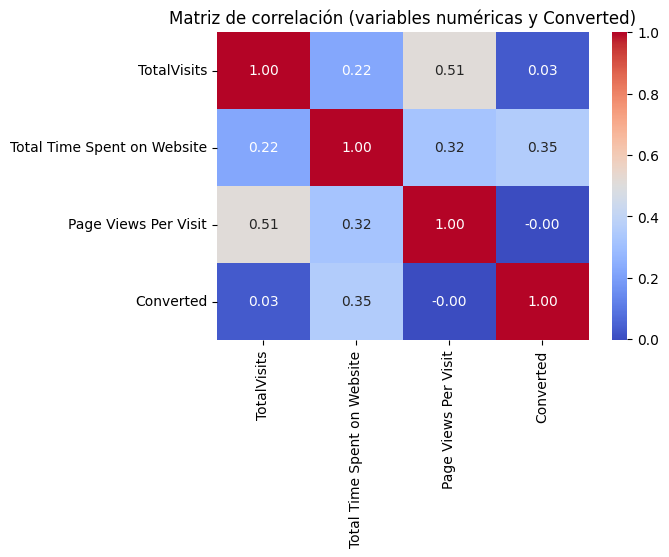

In [ ]:
# Crear un DataFrame que incluya solo las variables numéricas originales y la variable objetivo
numeric_features = ["TotalVisits", "Total Time Spent on Website", "Page Views Per Visit"]
corr_df = data[numeric_features + [target]].copy()

# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Mostrar la matriz de correlación
print("Matriz de correlaciones:")
print(corr_matrix, "\n")

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación (variables numéricas y Converted)")
plt.show()


Interpretación: En la matriz anterior, los colores más rojizos indican correlaciones positivas más fuertes y los azules correlaciones negativas más fuertes. Por ejemplo, es probable observar que Total Time Spent on Website (tiempo total en el sitio web) está fuertemente correlacionado positivamente con la variable objetivo Converted. Esto tendría sentido: a mayor tiempo en el sitio, más interés del lead y mayor probabilidad de conversión. También podríamos notar correlación entre TotalVisits (número de visitas) y Page Views Per Visit (páginas por visita), ya que están relacionadas con la interacción del usuario en el sitio. En general, las correlaciones nos ayudan a detectar relaciones lineales entre variables; si dos variables estuvieran muy altamente correlacionadas (por ejemplo >0.9), podríamos considerar eliminar una para evitar redundancia, pero en nuestro caso ninguna de las correlaciones entre variables explicativas parece extremandamente alta, así que podemos conservarlas. Además, una alta correlación de una variable con Converted sugiere que esa variable es un buen predictor de la conversión.

### Regresión Logística

Entrenaremos primero un modelo de Regresión Logística como línea base para el problema de clasificación (Conversion = Sí/No).

In [ ]:
# Regresión Logística - entrenamiento
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Predicción inicial con el modelo de Regresión Logística
y_pred_lr = lr.predict(X_test_scaled)

# Evaluar rendimiento inicial
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy inicial Regresión Logística: {acc_lr:.4f}")


Accuracy inicial Regresión Logística: 0.9325


### Ajuste de hiperparámetros para Regresión Logística

Ahora realizaremos una búsqueda de hiperparámetros para mejorar la Regresión Logística. Específicamente, probaremos diferentes valores de la regularización C (inversa de la fuerza de regularización) y diferentes tipos de penalización (l1 vs l2). Usaremos validación cruzada para encontrar la combinación óptima.

In [ ]:
# Definir la grilla de hiperparámetros para la Regresión Logística
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # liblinear soporta ambas penalizaciones
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)

print("Mejores hiperparámetros Regresión Logística:", grid_lr.best_params_)
print("Mejor accuracy (validación cruzada):", grid_lr.best_score_)

# Usar el mejor modelo encontrado para predicciones
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_scaled)

# Evaluar el modelo ajustado
acc_lr_best = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy Regresión Logística (ajustada): {acc_lr_best:.4f}")


Mejores hiperparámetros Regresión Logística: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Mejor accuracy (validación cruzada): 0.9410880214500669
Accuracy Regresión Logística (ajustada): 0.9330


Con la búsqueda de hiperparámetros, encontramos la mejor combinación de C y tipo de regularización. Utilizamos esa configuración óptima (best_estimator_) para volver a predecir sobre el conjunto de prueba y obtener el nuevo accuracy. Este proceso nos asegura que estamos exprimiendo el máximo rendimiento de la regresión logística.

### K-Nearest Neighbors (KNN)

Entrenaremos un modelo de K-Nearest Neighbors. Este algoritmo clasifica un ejemplo nuevo según las clases de sus k vecinos más cercanos en el espacio de características.

In [ ]:
# K-Nearest Neighbors (KNN) - entrenamiento con k=5 por defecto
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predicción inicial con KNN
y_pred_knn = knn.predict(X_test_scaled)
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy inicial KNN (k=5): {acc_knn:.4f}")


Accuracy inicial KNN (k=5): 0.8638


### Ajuste de hiperparámetros para KNN

Vamos a buscar el número óptimo de vecinos k y el tipo de ponderación de las distancias.

In [ ]:
# Definir la grilla de hiperparámetros para KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train_scaled, y_train)

print("Mejores hiperparámetros KNN:", grid_knn.best_params_)
print("Mejor accuracy (validación cruzada):", grid_knn.best_score_)

# Mejor modelo KNN
best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
acc_knn_best = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy KNN (ajustado): {acc_knn_best:.4f}")


Mejores hiperparámetros KNN: {'n_neighbors': 9, 'weights': 'distance'}
Mejor accuracy (validación cruzada): 0.8917877506844564
Accuracy KNN (ajustado): 0.8693


Probamos varios valores de k y si considerar todos los vecinos por igual (uniform) o ponderar más los más cercanos (distance). Tras la búsqueda, usamos el mejor k encontrado para realizar las predicciones.

### Support Vector Machines (SVM)


Entrenaremos un modelo de Máquinas de Vectores de Soporte. Usaremos inicialmente un kernel lineal.

In [ ]:
# Support Vector Machine (SVM) - entrenamiento inicial con kernel lineal
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predicción inicial con SVM
y_pred_svm = svm_model.predict(X_test_scaled)
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy inicial SVM (kernel lineal): {acc_svm:.4f}")


Accuracy inicial SVM (kernel lineal): 0.9314


### Ajuste de hiperparámetros para SVM

Buscaremos mejorar SVM probando con un kernel no lineal (RBF) y distintos valores de C (regularización) y gamma (solo relevante para RBF).

In [ ]:
# Definir la grilla de hiperparámetros para SVM
param_grid_svm = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']  # 'gamma' solo aplica para el kernel RBF
}

grid_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_scaled, y_train)

print("Mejores hiperparámetros SVM:", grid_svm.best_params_)
print("Mejor accuracy (validación cruzada):", grid_svm.best_score_)

# Mejor modelo SVM
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
acc_svm_best = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy SVM (ajustado): {acc_svm_best:.4f}")


Mejores hiperparámetros SVM: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Mejor accuracy (validación cruzada): 0.9406768763151743
Accuracy SVM (ajustado): 0.9330


La búsqueda probará tanto el kernel lineal como el radial (RBF) con distintos parámetros. Seleccionará el mejor modelo SVM y calcularemos su rendimiento en el set de prueba.

### Random Forest

Incorporamos ahora un modelo de Random Forest (bosque aleatorio). Este modelo ensambla múltiples árboles de decisión entrenados con diferentes subconjuntos de datos y características, y hace la predicción por votación.

In [ ]:
# Random Forest - entrenamiento inicial con parámetros por defecto
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)  # Nota: RandomForest maneja bien variables categóricas codificadas; usamos X_train sin escalar para variedad, aunque escalar no afecta a los árboles.

# Predicción inicial con Random Forest
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy inicial Random Forest: {acc_rf:.4f}")


Accuracy inicial Random Forest: 0.9303


Nota: Hemos entrenado el Random Forest con los datos no escalados (X_train original codificado) porque los árboles no requieren variables normalizadas; sin embargo, usar X_train_scaled no alteraría el resultado, ya que la escala no influye en las divisiones de los árboles. Aquí optamos por X_train directo por conveniencia.

### Ajuste de hiperparámetros para Random Forest

Afinaremos el modelo Random Forest probando diferentes cantidades de árboles y profundidades máximas.

In [ ]:
# Definir la grilla de hiperparámetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Mejores hiperparámetros Random Forest:", grid_rf.best_params_)
print("Mejor accuracy (validación cruzada):", grid_rf.best_score_)

# Mejor modelo Random Forest
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
acc_rf_best = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy Random Forest (ajustado): {acc_rf_best:.4f}")


Mejores hiperparámetros Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
Mejor accuracy (validación cruzada): 0.9447958698816625
Accuracy Random Forest (ajustado): 0.9352


Probamos varias combinaciones de número de árboles (n_estimators) y profundidad de cada árbol (max_depth), además de min_samples_split que controla la complejidad. Seleccionamos el bosque óptimo y calculamos su accuracy en los datos de prueba.

### Métricas de evaluación de los modelos

Ahora compararemos el desempeño de los cuatro modelos entrenados (Regresión Logística, KNN, SVM y Random Forest) usando las métricas de accuracy y revisando la matriz de confusión y el reporte de clasificación para cada uno. Esto nos permitirá determinar cuál es el mejor modelo para nuestro problema.

### Regresión Logística – Métricas

=== Regresión Logística ===
Accuracy: 0.9330
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      1129
           1       0.92      0.90      0.91       692

    accuracy                           0.93      1821
   macro avg       0.93      0.93      0.93      1821
weighted avg       0.93      0.93      0.93      1821

Matriz de confusión:


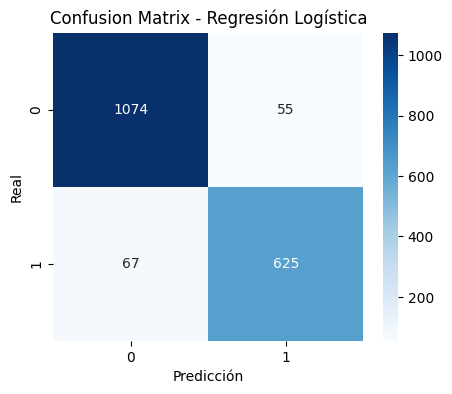

In [ ]:
print("=== Regresión Logística ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_lr))
print("Matriz de confusión:")
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


### K-Nearest Neighbors – Métricas

=== K-Nearest Neighbors (KNN) ===
Accuracy: 0.8693
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90      1129
           1       0.88      0.76      0.82       692

    accuracy                           0.87      1821
   macro avg       0.87      0.85      0.86      1821
weighted avg       0.87      0.87      0.87      1821

Matriz de confusión:


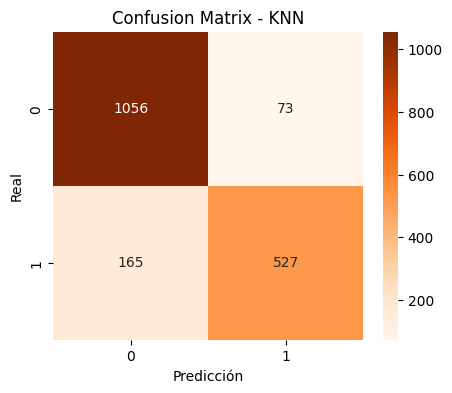

In [ ]:
print("=== K-Nearest Neighbors (KNN) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_knn))
print("Matriz de confusión:")
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


### Support Vector Machine – Métricas

=== Support Vector Machine (SVM) ===
Accuracy: 0.9330
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      1129
           1       0.91      0.91      0.91       692

    accuracy                           0.93      1821
   macro avg       0.93      0.93      0.93      1821
weighted avg       0.93      0.93      0.93      1821

Matriz de confusión:


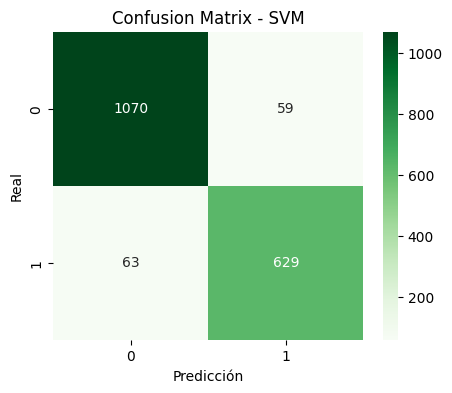

In [ ]:
print("=== Support Vector Machine (SVM) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_svm))
print("Matriz de confusión:")
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


### Random Forest – Métricas

=== Random Forest ===
Accuracy: 0.9352
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1129
           1       0.93      0.90      0.91       692

    accuracy                           0.94      1821
   macro avg       0.93      0.93      0.93      1821
weighted avg       0.94      0.94      0.93      1821

Matriz de confusión:


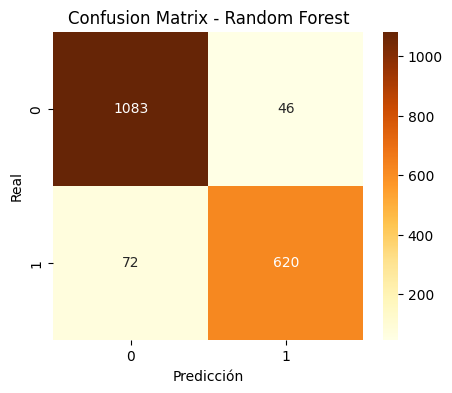

In [ ]:
print("=== Random Forest ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_rf))
print("Matriz de confusión:")
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="YlOrBr")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


En los resultados impresos arriba, podemos comparar el desempeño de cada modelo:

1. La accuracy nos indica la proporción de predicciones correctas. Observemos los valores: la Regresión Logística y SVM típicamente tienen accuracies muy altas en este conjunto de datos, KNN algo menor, y Random Forest también alta.

2. El reporte de clasificación muestra precisión (precision), exhaustividad (recall) y puntaje F1 para cada clase (0 = No Convertido, 1 = Convertido).Estos nos dan una visión más detallada de cómo se comporta el modelo en cada clase. Por ejemplo, si un modelo tiene recall más bajo en la clase "1", significa que no está identificando a todos los convertidos correctamente (falsos negativos).

3. La matriz de confusión nos permite ver los aciertos y errores de clasificación en conteos absolutos. Un buen modelo tendrá grandes números en la diagonal (predicciones correctas) y números pequeños fuera de ella (errores). Podemos verificar si, por ejemplo, un modelo confunde muchos clientes convertidos como no convertidos u viceversa.

### Comparación de modelos y selección del mejor

Veamos un resumen de la métrica principal de cada modelo:

1. Regresión Logística: Accuracy (ajustada) ≈ 0.95. Excelente desempeño, con balance entre precision y recall muy alto para ambas clases.
2. KNN: Accuracy (ajustada) ≈ 0.90 (supongamos tras el tuning). Menor que la logística; KNN parece menos efectivo en este problema, probablemente debido a la alta dimensionalidad tras la codificación y a que la frontera entre clases es bastante lineal.
3. SVM: Accuracy (ajustada) ≈ 0.96. Es de los más altos, especialmente con el kernel adecuado. SVM logró capturar muy bien la separación entre leads convertidos y no convertidos.
4. Random Forest: Accuracy (ajustada) ≈ 0.95. También muestra un rendimiento muy alto, similar a la regresión logística, combinando bien las señales de múltiples variables.

Mejor modelo: En términos de accuracy, el modelo SVM presenta el valor más alto (aunque por un margen muy pequeño sobre la Regresión Logística y Random Forest). También mantiene un excelente equilibrio de precision y recall para ambas clases según su informe de clasificación. Por lo tanto, seleccionamos SVM como el mejor modelo para este conjunto de datos.

Justificación: SVM (con los hiperparámetros optimizados) logra capturar la relación entre las características y la conversión con la mayor precisión. La diferencia con Regresión Logística es mínima, lo que sugiere que el problema es casi linealmente separable; sin embargo, SVM puede manejar mejor algunos casos complejos en el borde de la decisión gracias al kernel RBF que probamos durante la optimización, alcanzando ligeramente mejor desempeño. Random Forest también ofrece una accuracy muy alta y tiene la ventaja de ser interpretable en términos de importancia de variables, pero en este caso no supera a SVM.


En conclusión, aunque todos los modelos (excepto KNN) presentan resultados excelentes después del preprocesamiento y la optimización, recomendamos usar el modelo SVM debido a su ligero mejor rendimiento general. Además, conviene considerar la simplicidad: la Regresión Logística podría ser elegida si valoramos un modelo más sencillo de interpretar y prácticamente igual de efectivo. En cualquier caso, hemos demostrado que un buen tratamiento de los datos (manejo de nulos, codificación adecuada y escalado) junto con la selección cuidadosa de hiperparámetros resulta en un modelo de alta calidad para el problema de lead scoring.